## Redes neurais
Na aula de hoje, veremos como implementar redes neurais utilizando o _pytorch_. Utilizaremos também o dataset _Diabetes_, da aula 07, onde tentaremos prever a presença da doença com um modelo de classificação.

##### Carregando o dataset

In [1]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
import numpy as np
import time
pd.set_option('display.max_columns', None)
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

In [2]:
df = pd.concat([cdc_diabetes_health_indicators.data.features, cdc_diabetes_health_indicators.data.targets], axis=1)

In [3]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [4]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
model_cols = [c for c in df.columns if c!='Diabetes_binary']

In [5]:
model_cols_raw = [c for c in df.columns if c!='Diabetes_binary']
model_cols_raw

['HighBP',
 'HighChol',
 'CholCheck',
 'BMI',
 'Smoker',
 'Stroke',
 'HeartDiseaseorAttack',
 'PhysActivity',
 'Fruits',
 'Veggies',
 'HvyAlcoholConsump',
 'AnyHealthcare',
 'NoDocbcCost',
 'GenHlth',
 'MentHlth',
 'PhysHlth',
 'DiffWalk',
 'Sex',
 'Age',
 'Education',
 'Income']

Vamos ajustar um StandardScaler() sobre os dados. Faremos esse ajuste sobre o conjunto completo para facilitar a comparação, mas na prática é importante ajustar os scalers para o modelo final escolhido somente sobre o conjunto de treino.

Note que esta etapa não é necessária para o baseline que vamos ajustar, mas é necessária para as redes neurais.

In [6]:
from sklearn.preprocessing import StandardScaler
model_cols = [c+'_norm' for c in model_cols_raw]

scaler = StandardScaler()
df[model_cols] = scaler.fit_transform(df[model_cols_raw])

Vamos ajustar então uma Random Forest sobre os dados e calcular a ROC-AUC com validação cruzada:

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

params = {'n_estimators':200,
          'n_jobs':-1,
          'criterion':'gini',
          'max_depth':None}

print('ROC-AUC média cross-val:', np.mean(cross_val_score(estimator=RandomForestClassifier(**params),
                                    X=df[model_cols], y=df['Diabetes_binary'], cv=5, scoring='roc_auc', n_jobs=-1)))

ROC-AUC média cross-val: 0.7783933818776347


In [8]:
# Separação treino-teste-validação
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

##### Configurando pytorch
Vamos configurar a biblioteca para executar na GPU ou CPU. A função `torch.cuda.is_available()` retorna se há implementação CUDA (NVidia) instalada disponível para ser utilizada.

In [11]:
import torch
print('Cuda disponível:', torch.cuda.is_available())
# Escolhendo entre CPU ou GPU
# CPU
device = torch.device('cpu')
# GPU
# device = torch.device('cuda:0')
print(device)

Cuda disponível: False
cpu


##### Configurando dataset de treino

Para a implementação de redes neurais no pytorch, precisaremos transformar os dados em _tensores_. Essas estruturas são uma generalização de vetores e matrizes para espaços mais complexos: uma imagem pode ser vista como um cubo parecido com uma "matriz 3D", onde cada índice e coluna representam as coordenadas dos pixels, e cada "camada" na terceira dimensão representa um canal de cor (R, G, B).

A variável resposta não está no formato tensorial adequado após a conversão utilizando o `torch.tensor()`, e é necessário "adicionar" uma "dimensão" no tensor com o unsqueeze

In [12]:
import torch

# Colocando em tensores do pytorch
train_features = torch.tensor(df_train[model_cols].values.astype(np.float32)).to(device)
train_target = torch.tensor(df_train['Diabetes_binary'].values.astype(np.float32)).to(device).unsqueeze(1)
print(f'Features:\n{train_features}\n')
print(f'Targets:\n{train_target}')

Features:
tensor([[-0.9125, -0.8894,  0.2055,  ..., -1.3201,  0.0204,  0.5310],
        [-0.9125,  1.1244,  0.2055,  ...,  0.9420, -0.9867, -0.9024],
        [ 1.0959, -0.8894,  0.2055,  ...,  1.2651,  1.0275,  1.0088],
        ...,
        [-0.9125,  1.1244,  0.2055,  ...,  0.6188,  0.0204,  1.0088],
        [ 1.0959,  1.1244,  0.2055,  ...,  0.6188,  1.0275,  1.0088],
        [-0.9125, -0.8894,  0.2055,  ...,  1.2651, -1.9937, -1.3802]])

Targets:
tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [1.],
        [0.]])


Vamos precisar configurar também _dataloaders_, que "embrulham" os dados em pacotes iteráveis no formato necessário. Para isso, precisaremos definir um hiperparâmetro muito importante: o `batch_size`. Esse hiperparâmetro define o tamanho dos "pacotes" de amostras que são processados na rede neural por vez. Caso tenhamos 100 amostras totais e batch_size=20, uma "passada completa" dos dados na rede (_epoch_) leva 5 iterações, onde o gradiente é calculado e retropropagado a cada iteração.

Valores muito pequenos para este hiperparâmetro podem prejudicar bastante o treinamento (e induzir overfitting) devido à alta variância resultante dos "pacotes" - será comum, por exemplo, _batches_ com somente uma classe. Por outro lado, batches muito grandes podem ser generalistas demais.

Controlar o `batch_size` é principalmente um jeito de controlar os requisitos de memória para treinar uma rede neural: quanto maior forem os batches, mais memória (da GPU) será necessária - em contrapartida, mais rápido será o treinamento.

In [13]:
# Definindo 256 amostras por batch
batch_size = 256

In [14]:
# Configurando dataloader
from torch.utils.data import TensorDataset, DataLoader
train_tensor = TensorDataset(train_features, train_target)
train_dl = DataLoader(dataset=train_tensor, batch_size=batch_size, shuffle=True)

In [15]:
train_tensor

##### Configurando dataset de teste

In [16]:
test_features = torch.tensor(df_test[model_cols].values.astype(np.float32))
test_target = torch.tensor(df_test['Diabetes_binary'].values.astype(np.float32)).unsqueeze(1)
test_tensor = TensorDataset(test_features, test_target)
test_dl = DataLoader(dataset=test_tensor, batch_size=batch_size, shuffle=True)

In [17]:
for X,y in train_dl:
    train_features, train_labels = next(iter(train_dl))
    print(f'X: {X.shape}')
    print(f'y: {y.shape} {y.type()}')
    break

X: torch.Size([256, 21])
y: torch.Size([256, 1]) torch.FloatTensor


##### Construindo a rede neural

Chegou a hora de construirmos a rede de fato! Para isso, vamos utilizar um pouco de orientação a objetos e definir o atributo um atributo _feedforward_ da rede que representa uma sequência de passos (camadas), capturados pelo módulo `nn.Sequential()` do pytorch. Também poderíamos definir cada camada em um atributo, o que é importante para redes mais complexas.

Documentação relevante: https://pytorch.org/docs/stable/nn.html

In [20]:
from torch import nn
# Definindo o modelo
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.feedforward = nn.Sequential(
            nn.Linear(21, 64),
            nn.Sigmoid(),
            nn.Linear(64, 32),
            nn.Sigmoid(),
            nn.Linear(32, 16),
            nn.Sigmoid(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.feedforward(x)


model = NeuralNetwork().to(device)
print(list(model.parameters()))

[Parameter containing:
tensor([[ 0.1858,  0.0875, -0.1436,  ..., -0.0704,  0.1242,  0.0660],
        [-0.1864,  0.0326, -0.1515,  ..., -0.1166,  0.1462, -0.1859],
        [-0.1423,  0.0058, -0.2103,  ...,  0.2028, -0.0615,  0.2032],
        ...,
        [ 0.1551, -0.1869, -0.1535,  ..., -0.1158, -0.1137,  0.2174],
        [ 0.1283, -0.1754,  0.0672,  ...,  0.0737, -0.1517,  0.1268],
        [ 0.1147,  0.2048,  0.0646,  ...,  0.1334,  0.0478,  0.0631]],
       requires_grad=True), Parameter containing:
tensor([-9.4581e-02, -1.2169e-01,  8.4738e-02, -1.8819e-01,  1.2866e-01,
        -1.3376e-01, -1.2368e-02,  9.9369e-02,  1.9179e-01,  1.1712e-05,
        -1.7567e-01, -1.7927e-01, -1.3028e-01,  6.0378e-02, -1.4390e-01,
         2.7736e-02,  9.5412e-02,  1.4601e-01, -1.5207e-01, -1.2666e-02,
         1.8363e-01, -6.9163e-02,  8.5760e-02,  1.6696e-01, -8.1215e-02,
        -1.5521e-01,  1.5486e-01,  1.9173e-01, -5.9557e-02,  1.8359e-01,
        -9.3741e-02,  5.8656e-02,  1.7543e-02,  7.6585e

Vamos definir agora mais alguns hiperparâmetros do treinamento/otimização:

In [21]:
# Hiperparâmetros do otimizador
learning_rate = 0.01
momentum = 0.1

# Loss
loss_fn = nn.BCELoss()

# Otimizador
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

E definir uma função que recebe os dados (dataloader), o modelo, a loss e um otimizador e efetivamente treina a rede, realizando o cálculo do gradiente e o backpropagation (retropropagação):

In [23]:
def trainloop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Calcula a loss
        prediction = model(X)
        loss = loss_fn(prediction, y)

        # Backpropagation
        # Zerar os gradientes (acumulam por passe)
        optimizer.zero_grad()
        # Calcular e definir o gradiente atual da loss
        loss.backward()
        # Dar um passo na direção oposta
        optimizer.step()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch*len(X)
        #     print(f'loss:{loss:>7f} [{current:>5d}/{size:>5d}]', end='\r')

E também uma função para avaliar o desempenho da rede, que acompanharemos a cada epoch.

In [24]:
from sklearn.metrics import roc_auc_score
def evaluate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    rocauc = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss = test_loss + loss_fn(pred, y)
            rocauc = rocauc + roc_auc_score(y.cpu(), pred.cpu())
    test_loss = test_loss / num_batches
    rocauc = rocauc / num_batches

    # Retornar string ou números?
    # return f'ROC-AUC: {(rocauc):.4f}, Avg loss: {test_loss:.4f}'
    return rocauc, test_loss

Agora podemos, finamente, treinar a rede! O treino acontece na chamada da função _trainloop()_ que definimos, e o resto do código é responsável pelas métricas e tempos que usaremos para acompanhar o treino.

Vamos treiná-la por 5 epochs:

In [25]:
from IPython.display import clear_output

epochs = 5
start_time = time.time()
for i in range(epochs):
    start_epoch_time = time.time()
    trainloop(train_dl, model, loss_fn, optimizer)
    train_metric_str = evaluate(train_dl, model, loss_fn)
    test_metric_str = evaluate(test_dl, model, loss_fn)
    clear_output(wait=True)
    print(f"Epoch {i+1}\n-------------------------------")
    print(f'Desempenho treino: {train_metric_str}')
    print(f'Desempenho teste: {test_metric_str}')
    end = time.time()
    print(f'Tempo última epoch: {np.round((end-start_epoch_time), 2)}s')
    print(f'Tempo total: {np.round((end-start_time), 2)}s ({np.round(((end-start_time)/60), 2)}min)')
print('Rede treinada.')

Epoch 5
-------------------------------
Desempenho treino: (0.674876032398252, tensor(0.4269))
Desempenho teste: (0.6767015720981421, tensor(0.4293))
Tempo última epoch: 4.95s
Tempo total: 24.53s (0.41min)
Rede treinada.


Já conseguimos uma ROC-AUC razoável! Vamos iterar o treinamento e plottar uma curva de loss e ROC-AUC:

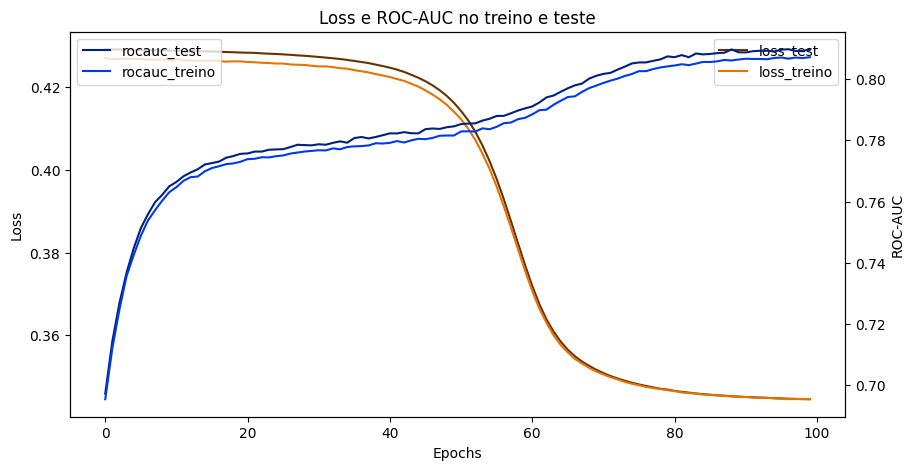

Rede treinada.
Última loss: 0.3445102870464325
Última ROC-AUC: 0.8095573807691395


In [26]:
import matplotlib.pylab as plt
%matplotlib inline

epochs = 100
start_time = time.time()
train_rocs, train_losses = [], []
test_rocs, test_losses = [], []

for i in range(epochs):
    start_epoch_time = time.time()
    trainloop(train_dl, model, loss_fn, optimizer)
    train_roc, train_loss = evaluate(train_dl, model, loss_fn)
    test_roc, test_loss = evaluate(test_dl, model, loss_fn)
    train_rocs += [train_roc]
    train_losses += [train_loss.cpu()]
    test_rocs += [test_roc]
    test_losses += [test_loss.cpu()]

    # Plottando gráficos de loss e roc-auc
    fig, ax1 = plt.subplots(figsize=(10, 5))
    plt.title('Loss e ROC-AUC no treino e teste')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.plot([t for t in test_losses], label='loss_test', c='#663300')
    ax1.plot([t for t in train_losses], label='loss_treino', c='#e67300')
    ax1.legend()
    ax2 = ax1.twinx()
    ax2.set_ylabel('ROC-AUC')
    ax2.plot([t for t in test_rocs], label='rocauc_test', c='#002080')
    ax2.plot([t for t in train_rocs], label='rocauc_treino', c='#0039e6')
    ax2.legend()
    plt.show()
    if i != epochs-1:
        clear_output(wait=True)

print('Rede treinada.')
print(f'Última loss: {test_loss.cpu()}')
print(f'Última ROC-AUC: {test_roc}')

### Exercícios
- Nesse dataset, podemos pensar como um problema de duas classes exclusivas - pacientes com diabetes e pacientes sem diabetes. Modele o problema utilizando uma saída de duas classes na rede neural e uma _softmax_ e treine a rede resultante. Compare com o desempenho da rede sigmoide.
- Observe a diminuição dos ganhos de desempenho conforme as epochs passam. Faz sentido continuar treinando o modelo quando observamos ganhos apenas marginais? Descreva um possível critério de parada (convergência).
- Exiba a diferença de complexidade entre uma rede com poucos neurônios e uma com muitos fazendo
    - uma comparação treinando ambas as redes e anotando o tempo por epoch, ou
    - calcule quantas arestas uma rede tem a mais que a outra.